In [1]:
import numpy as np 
import pandas as pd 
import datetime
import re
import os, os.path
import time
from sklearn.model_selection import train_test_split
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
cd ../Training_Data

/app/data/Training_Data


In [3]:
sb.set_palette("husl",3)
sb.set_style("whitegrid")

In [4]:
train_set = pd.read_csv('processed_train_set.csv',converters={'acceleration': eval})
test_set = pd.read_csv('processed_test_set.csv',converters={'acceleration': eval})
val_set = pd.read_csv('processed_val_set.csv',converters={'acceleration': eval})

In [ ]:
cd ../Model

In [5]:
def calculate_model_size(model):
    print(model.summary())
    var_sizes = [
      np.product(list(map(int, v.shape))) * v.dtype.size
      for v in model.trainable_variables
      ]
    print("Model size:", sum(var_sizes) / 1024, "KB")

In [6]:
samples = len(train_set['acceleration'][0])

lstm_model = tf.keras.Sequential([
      tf.keras.layers.Bidirectional(
          tf.keras.layers.LSTM(22),
          input_shape=(samples, 3)),  # output_shape=(batch, 44)
      tf.keras.layers.Dense(4, activation="sigmoid")  # (batch, 4)
])

cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (4, 3),padding="same",activation="relu",
                           input_shape=(samples, 3, 1)),  # output_shape=(batch, 128, 3, 8)
    tf.keras.layers.MaxPool2D((3, 3)),  # (batch, 42, 1, 8)
    tf.keras.layers.Dropout(0.1),  # (batch, 42, 1, 8)
    tf.keras.layers.Conv2D(16, (4, 1), padding="same",activation="relu"),  # (batch, 42, 1, 16)
    tf.keras.layers.MaxPool2D((3, 1), padding="same"),  # (batch, 14, 1, 16)
    tf.keras.layers.Dropout(0.1),  # (batch, 14, 1, 16)
    tf.keras.layers.Flatten(),  # (batch, 224)
    tf.keras.layers.Dense(16, activation="relu"),  # (batch, 16)
    tf.keras.layers.Dropout(0.1),  # (batch, 16)
    tf.keras.layers.Dense(4, activation="softmax")  # (batch, 4)
])

cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, (4, 3),padding="same",activation="relu",
                           input_shape=(samples, 3, 1)),  # output_shape=(batch, 128, 3, 8)
    tf.keras.layers.MaxPool2D((3, 3)),  # (batch, 42, 1, 8)
    tf.keras.layers.Dropout(0.1),  # (batch, 42, 1, 8)
    tf.keras.layers.Conv2D(16, (4, 1), padding="same",activation="relu"),  # (batch, 42, 1, 16)
    tf.keras.layers.MaxPool2D((3, 1), padding="same"),  # (batch, 14, 1, 16)
    tf.keras.layers.Dropout(0.1),  # (batch, 14, 1, 16)
    tf.keras.layers.Flatten(),  # (batch, 224)
    tf.keras.layers.Dense(16, activation="relu"),  # (batch, 16)
    tf.keras.layers.Dropout(0.1),  # (batch, 16)
    tf.keras.layers.Dense(4, activation="softmax")  # (batch, 4)
])

In [7]:
tensor_train_set = tf.data.Dataset.from_tensor_slices(
    (np.array(train_set['acceleration'].tolist(),dtype=np.float64),
     train_set['gesture'].tolist()))

tensor_test_set = tf.data.Dataset.from_tensor_slices(
    (np.array(test_set['acceleration'].tolist(),dtype=np.float64),
     test_set['gesture'].tolist()))

tensor_val_set = tf.data.Dataset.from_tensor_slices(
    (np.array(val_set['acceleration'].tolist(),dtype=np.float64),
     val_set['gesture'].tolist()))

In [15]:
calculate_model_size(lstm_model)
epochs_cnn = 20
epochs_lstm = 10
batch_size = 64
lstm_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

calculate_model_size(cnn_model)
cnn_model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

calculate_model_size(cnn_model2)
cnn_model2.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 44)                4576      
_________________________________________________________________
dense (Dense)                (None, 4)                 180       
Total params: 4,756
Trainable params: 4,756
Non-trainable params: 0
_________________________________________________________________
None
Model size: 18.578125 KB
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 760, 3, 8)         104       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 253, 1, 8)         0         
_________________________________________________________________
dropout (Dropout)            (None, 253, 1, 8)         0         
__

In [9]:
tensor_train_set_lstm = tensor_train_set.batch(batch_size).repeat()
tensor_val_set_lstm = tensor_val_set.batch(batch_size)
tensor_test_set_lstm = tensor_test_set.batch(batch_size)

In [16]:
history = lstm_model.fit(
    tensor_train_set_lstm,
    epochs=epochs_lstm,
    validation_data=tensor_val_set_lstm,
    steps_per_epoch=200,
    validation_steps=int((len(val_set) - 1) / batch_size + 1))

Epoch 1/16
200/200 [==============================] - 35s 177ms/step - loss: 0.1742 - accuracy: 0.9442 - val_loss: 0.3731 - val_accuracy: 0.9118
Epoch 2/16
200/200 [==============================] - 35s 173ms/step - loss: 0.1800 - accuracy: 0.9446 - val_loss: 0.4699 - val_accuracy: 0.8529
Epoch 3/16
200/200 [==============================] - 34s 171ms/step - loss: 0.1297 - accuracy: 0.9607 - val_loss: 0.5107 - val_accuracy: 0.8676
Epoch 4/16
200/200 [==============================] - 34s 172ms/step - loss: 0.1813 - accuracy: 0.9500 - val_loss: 0.2181 - val_accuracy: 0.9118
Epoch 5/16
200/200 [==============================] - 34s 172ms/step - loss: 0.1429 - accuracy: 0.9613 - val_loss: 0.2020 - val_accuracy: 0.9412
Epoch 6/16
200/200 [==============================] - 34s 171ms/step - loss: 0.1550 - accuracy: 0.9605 - val_loss: 0.4928 - val_accuracy: 0.8824
Epoch 7/16
200/200 [==============================] - 35s 173ms/step - loss: 0.1063 - accuracy: 0.9713 - val_loss: 0.2907 - val_ac

In [17]:
loss_lstm, acc_lstm = lstm_model.evaluate(tensor_test_set_lstm)
pred_lstm = np.argmax(lstm_model.predict(tensor_test_set_lstm), axis=1)
confusion_lstm = tf.math.confusion_matrix(
    labels=tf.constant(test_set['gesture'].to_numpy()),
    predictions=tf.constant(pred_lstm),
    num_classes=4)

1/1 [==============================] - 0s 971us/step - loss: 0.2620 - accuracy: 0.9348


In [18]:
print(confusion_lstm)
print("Loss {}, Accuracy {}".format(loss_lstm, acc_lstm))

tf.Tensor(
[[12  0  2  0]
 [ 0 10  0  0]
 [ 0  0 14  0]
 [ 0  0  1  7]], shape=(4, 4), dtype=int32)
Loss 0.2619706988334656, Accuracy 0.9347826242446899


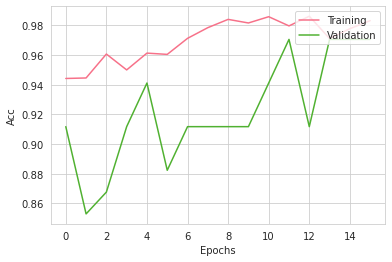

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['Training','Validation'],loc='upper right')

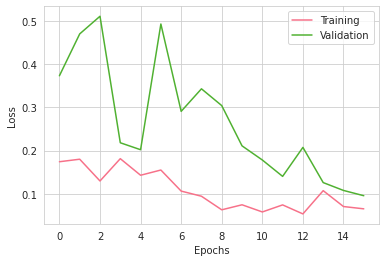

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training','Validation'],loc='upper right')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)
lstm_tflite_model = converter.convert()

open("lstm_model.tflite", "wb").write(lstm_tflite_model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(lstm_model)
converter.experimental_new_converter = True
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
converter.target_spec.supported_types = [tf.float16]
lstm_opt_tflite_model = converter.convert()
# Save the model to disk
open("lstm_model_quantized.tflite", "wb").write(lstm_opt_tflite_model)

In [ ]:
basic_model_size = os.path.getsize("lstm_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("lstm_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

In [13]:
def reshape_function(data, label):
    reshaped_data = tf.reshape(data, [-1, 3, 1])
    return reshaped_data, label

In [ ]:
train_set = pd.read_csv('processed_train_set.csv',converters={'acceleration': eval})
test_set = pd.read_csv('processed_test_set.csv',converters={'acceleration': eval})
val_set = pd.read_csv('processed_val_set.csv',converters={'acceleration': eval})

tensor_train_set = tf.data.Dataset.from_tensor_slices(
    (np.array(train_set['acceleration'].tolist(),dtype=np.float64),
     train_set['gesture'].tolist()))

tensor_test_set = tf.data.Dataset.from_tensor_slices(
    (np.array(test_set['acceleration'].tolist(),dtype=np.float64),
     test_set['gesture'].tolist()))

tensor_val_set = tf.data.Dataset.from_tensor_slices(
    (np.array(val_set['acceleration'].tolist(),dtype=np.float64),
     val_set['gesture'].tolist()))

In [14]:
tensor_train_set_cnn = tensor_train_set.map(reshape_function)
tensor_test_set_cnn = tensor_test_set.map(reshape_function)
tensor_val_set_cnn = tensor_val_set.map(reshape_function)

In [15]:
tensor_train_set_cnn = tensor_train_set_cnn.batch(batch_size).repeat()
tensor_test_set_cnn = tensor_test_set_cnn.batch(batch_size)
tensor_val_set_cnn = tensor_val_set_cnn.batch(batch_size)

In [34]:
history=cnn_model.fit(
    tensor_train_set_cnn,
    epochs=epochs_cnn,
    validation_data=tensor_val_set_cnn,
    steps_per_epoch=300,
    validation_steps=int((len(val_set) - 1) / batch_size + 1))

Epoch 1/20
300/300 [==============================] - 10s 35ms/step - loss: 0.0077 - accuracy: 0.9971 - val_loss: 0.5330 - val_accuracy: 0.9412
Epoch 2/20
300/300 [==============================] - 11s 37ms/step - loss: 0.0854 - accuracy: 0.9773 - val_loss: 0.4209 - val_accuracy: 0.9412
Epoch 3/20
300/300 [==============================] - 10s 34ms/step - loss: 0.0276 - accuracy: 0.9908 - val_loss: 0.2897 - val_accuracy: 0.9706
Epoch 4/20
300/300 [==============================] - 10s 32ms/step - loss: 0.0170 - accuracy: 0.9939 - val_loss: 0.2978 - val_accuracy: 0.9412
Epoch 5/20
300/300 [==============================] - 10s 33ms/step - loss: 0.0077 - accuracy: 0.9969 - val_loss: 0.2978 - val_accuracy: 0.9412
Epoch 6/20
300/300 [==============================] - 9s 32ms/step - loss: 0.0133 - accuracy: 0.9952 - val_loss: 0.2992 - val_accuracy: 0.9706
Epoch 7/20
300/300 [==============================] - 10s 34ms/step - loss: 0.0121 - accuracy: 0.9958 - val_loss: 0.2523 - val_accuracy: 

In [37]:
history2=cnn_model2.fit(
    tensor_train_set_cnn,
    epochs=epochs_cnn,
    validation_data=tensor_val_set_cnn,
    steps_per_epoch=200,
    validation_steps=int((len(val_set) - 1) / batch_size + 1))

Epoch 1/20
200/200 [==============================] - 7s 33ms/step - loss: 0.0114 - accuracy: 0.9963 - val_loss: 0.5964 - val_accuracy: 0.9706
Epoch 2/20
200/200 [==============================] - 7s 33ms/step - loss: 0.0170 - accuracy: 0.9946 - val_loss: 0.5799 - val_accuracy: 0.9706
Epoch 3/20
200/200 [==============================] - 7s 34ms/step - loss: 0.0135 - accuracy: 0.9958 - val_loss: 0.4974 - val_accuracy: 0.9706
Epoch 4/20
200/200 [==============================] - 7s 33ms/step - loss: 0.0167 - accuracy: 0.9952 - val_loss: 0.4473 - val_accuracy: 0.9706
Epoch 5/20
200/200 [==============================] - 7s 33ms/step - loss: 0.0273 - accuracy: 0.9929 - val_loss: 0.6802 - val_accuracy: 0.9706
Epoch 6/20
200/200 [==============================] - 7s 33ms/step - loss: 0.0086 - accuracy: 0.9976 - val_loss: 0.7594 - val_accuracy: 0.9706
Epoch 7/20
200/200 [==============================] - 7s 33ms/step - loss: 0.0109 - accuracy: 0.9967 - val_loss: 0.7250 - val_accuracy: 0.9706

In [38]:
loss_cnn, acc_cnn = cnn_model.evaluate(tensor_test_set_cnn)
pred_cnn = np.argmax(cnn_model.predict(tensor_test_set_cnn), axis=1)
confusion_cnn = tf.math.confusion_matrix(
    labels=tf.constant(test_set['gesture'].to_numpy()),
    predictions=tf.constant(pred_cnn),
    num_classes=4)

loss_cnn2, acc_cnn2 = cnn_model2.evaluate(tensor_test_set_cnn)
pred_cnn2 = np.argmax(cnn_model2.predict(tensor_test_set_cnn), axis=1)
confusion_cnn2 = tf.math.confusion_matrix(
    labels=tf.constant(test_set['gesture'].to_numpy()),
    predictions=tf.constant(pred_cnn2),
    num_classes=4)

1/1 [==============================] - 0s 4ms/step - loss: 0.1333 - accuracy: 0.9565


In [39]:
print(confusion_cnn)
print("Loss {}, Accuracy {}".format(loss_cnn, acc_cnn))
print(confusion_cnn2)
print("Loss {}, Accuracy {}".format(loss_cnn2, acc_cnn2))

tf.Tensor(
[[14  0  0  0]
 [ 0 10  0  0]
 [ 0  0 14  0]
 [ 0  0  0  8]], shape=(4, 4), dtype=int32)
Loss 0.0035759308375418186, Accuracy 1.0
tf.Tensor(
[[14  0  0  0]
 [ 0 10  0  0]
 [ 0  0 14  0]
 [ 2  0  0  6]], shape=(4, 4), dtype=int32)
Loss 0.13330048322677612, Accuracy 0.95652174949646


In [15]:
history.history

{'loss': [0.5136839151382446,
  0.17093397676944733,
  0.09711793810129166,
  0.056820839643478394,
  0.043284785002470016,
  0.032811589539051056,
  0.02892693318426609,
  0.0321480967104435,
  0.015182502567768097,
  0.01316838338971138,
  0.013631793670356274,
  0.017973553389310837,
  0.010530445724725723,
  0.02079193666577339,
  0.011170466430485249,
  0.009354963898658752,
  0.008493409492075443,
  0.009281544014811516,
  0.016916070133447647,
  0.008460081182420254],
 'accuracy': [0.8091857433319092,
  0.933695912361145,
  0.9632602334022522,
  0.9786374568939209,
  0.98592609167099,
  0.9903797507286072,
  0.989861011505127,
  0.9892560839653015,
  0.9947969317436218,
  0.9954919815063477,
  0.9955671429634094,
  0.9942982196807861,
  0.9964474439620972,
  0.9941366910934448,
  0.9963558912277222,
  0.9967146515846252,
  0.9971569776535034,
  0.9972648620605469,
  0.995067834854126,
  0.9972805380821228],
 'val_loss': [0.26810377836227417,
  0.3351907730102539,
  0.34542360901

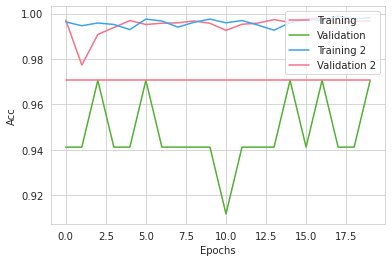

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])


plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])

plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend(['Training','Validation','Training 2', 'Validation 2'],loc='upper right')


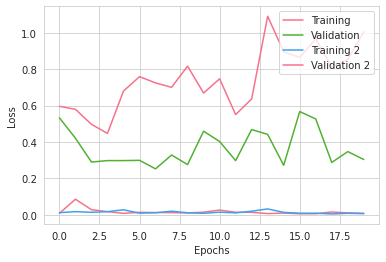

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])


plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training','Validation','Training 2', 'Validation 2'],loc='upper right')



In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
cnn_tflite_model = converter.convert()

 open("cnn_model.tflite", "wb").write(cnn_tflite_model)

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
cnn_opt_tflite_model = converter.convert()
# Save the model to disk
open("cnn_model_quantized.tflite", "wb").write(cnn_opt_tflite_model)

In [ ]:
basic_model_size = os.path.getsize("cnn_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("cnn_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

In [ ]:
# Install xxd if it is not available
#!apt-get -qq install xxd
# Save the file as a C source file
#!xxd -i cnn_model_quantized.tflite > cnn_opt_model.cc
# Print the source file
#!cat /cnn_opt_model.cc